<a href="https://colab.research.google.com/github/anushan1989/Waster_Segregation_CNN/blob/main/Anu_CNN_Waste_Segregation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Waste Material Segregation for Improving Waste Management


```
Objective

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

    Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
    Improve waste segregation efficiency to support recycling and reduce landfill waste.
    Understand the properties of different waste materials to optimise sorting methods for sustainability.

```



Data Understanding

The Dataset consists of images of some common waste materials.

    Food Waste
    Metal
    Paper
    Plastic
    Other
    Cardboard
    Glass




Data Description

    The dataset consists of multiple folders, each representing a specific class, such as Cardboard, Food_Waste, and Metal.
    Within each folder, there are images of objects that belong to that category.
    However, these items are not further subcategorised.
    For instance, the Food_Waste folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.



1. Load the data

Load and unzip the dataset zip file.


Import Necessary Libraries

# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os # Import the os module
import cv2
import sklearn
from PIL import Image as im
from glob import glob
from google.colab import drive
from sklearn.model_selection import train_test_split
import keras
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import preprocess_input
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import zipfile # Import the zipfile module

In [17]:
from google.colab import drive
print(os.getcwd())
drive.mount('/content/drive')

/content
Mounted at /content/drive


In [18]:
# Load and unzip the dataset
# Assuming the dataset zip file is named 'waste_dataset.zip'
# Uncomment the following lines when working with the actual zip file

with zipfile.ZipFile('/content/drive/MyDrive/Colab_Notebooks/data.zip', 'r') as zip_ref:
    zip_ref.extractall('Garbage_classification')


In [19]:
# Path to the dataset directory
#dataset_path = 'Garbage_classification/data/Paper'  # Update this path as needed
import os
data_path = '/content/Garbage_classification/data'
os.listdir(data_path)

['Glass', 'Other', 'Metal', 'Cardboard', 'Food_Waste', 'Plastic', 'Paper']

In [8]:
BATCH_SIZE = 64
img_height = 128
img_width = 128

In [20]:
import tensorflow as tf
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    validation_split = 0.2,
    subset = 'training',
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    batch_size = BATCH_SIZE,
    seed = 123,
    #Limit the number of training samples
    #labels = ['0', '1', '2', '3', '4', '5'][:2000] #Limit the number of labels to 2000)
)

Found 7625 files belonging to 7 classes.
Using 6100 files for training.


In [21]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    validation_split = 0.2,
    subset = 'validation',
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    batch_size = BATCH_SIZE,
    seed = 123)

Found 7625 files belonging to 7 classes.
Using 1525 files for validation.


In [22]:
class_names = train_ds.class_names
print(class_names)

['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic']


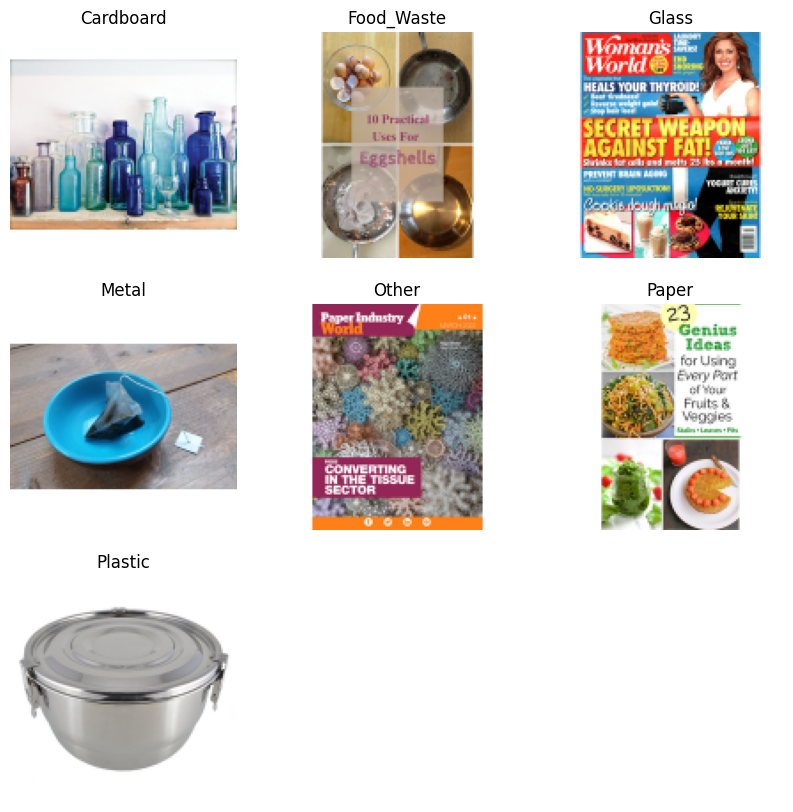

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(len(class_names)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential([
    #layers.CenterCrop(125, 125),
    layers.RandomFlip('horizontal', input_shape = (img_height, img_width, 3)),
    layers.RandomRotation(0.2, fill_mode = 'nearest'),
    layers.RandomZoom(0.1),
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


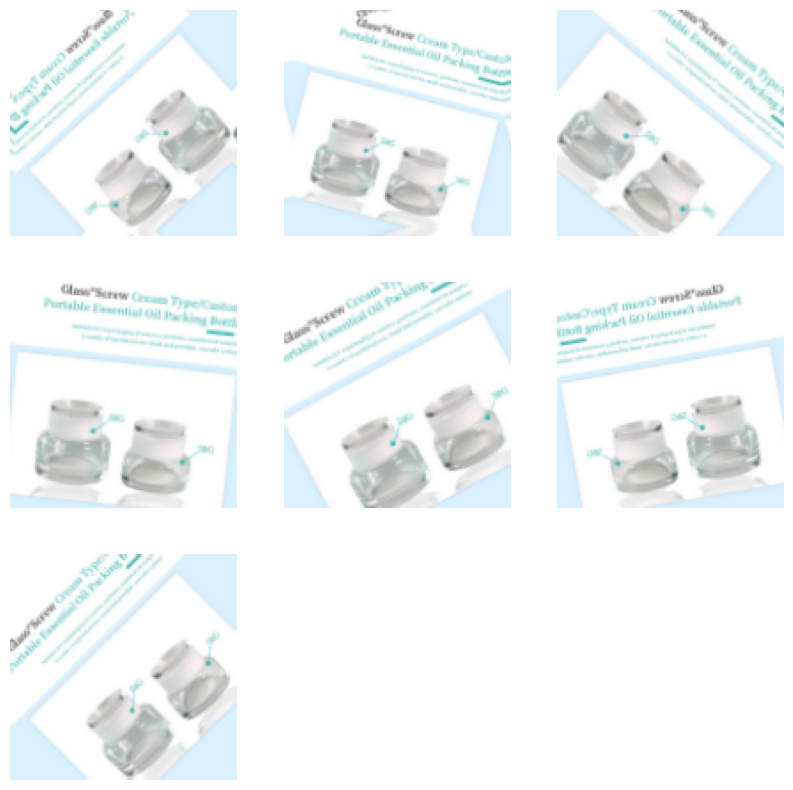

In [13]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(len(class_names)):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
   # plt.title(class_names[2])
    plt.axis("off")

In [14]:


AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)



In [15]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (img_height, img_width, 3)
base_model = tf.keras.applications.VGG16(input_shape = IMG_SHAPE,
                                         include_top = False,
                                         weights = 'imagenet')
#base_model.trainable = False
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
def print_layer_trainable():
    for layer in base_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

In [17]:
print_layer_trainable()

True:	input_layer_1
True:	block1_conv1
True:	block1_conv2
True:	block1_pool
True:	block2_conv1
True:	block2_conv2
True:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


In [18]:
# Unfreeze some layers of the base model
#base_model.trainable = True

In [19]:
base_model.trainable = False

for layer in base_model.layers:
    if 'block5' in layer.name or 'block4' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False



In [20]:
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal', input_shape = (img_height, img_width, 3)),
    layers.RandomRotation(0.2, fill_mode = 'nearest'),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),  # Added random contrast adjustment
    # Add more augmentation techniques as needed
])

In [21]:
n_classes = len(class_names)

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation = 'softmax')
])

In [22]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,781,255 (56.39 MB)

 Trainable params: 13,045,767 (49.77 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

In [23]:
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])



In [24]:
# Model Chackpoint
tl_checkpoint_1 = ModelCheckpoint(filepath = 'vgg16_best_weights.hdf5.keras', save_best_only = True, verbose = 0)

# EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True, mode = 'min')

# Import ReduceLROnPlateau
from tensorflow.keras.callbacks import ReduceLROnPlateau

# ReduceLROnPlateau
rop_callback = ReduceLROnPlateau(monitor = 'val_loss', patience = 2,  # Reduced patience
                                verbose = 1, factor = 0.5, min_lr = 0.000001)

In [25]:


%%time
history = model.fit(train_ds,
                    epochs = 10,
                    validation_data = val_ds,
                    callbacks = [tl_checkpoint_1, early_stop, rop_callback])

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2815s 29s/step - accuracy: 0.3109 - loss: 1.7835 - val_accuracy: 0.5580 - val_loss: 1.2672 - learning_rate: 1.0000e-04
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2794s 29s/step - accuracy: 0.5567 - loss: 1.2693 - val_accuracy: 0.5679 - val_loss: 1.1834 - learning_rate: 1.0000e-04
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2741s 29s/step - accuracy: 0.6208 - loss: 1.0806 - val_accuracy: 0.5443 - val_loss: 1.3150 - learning_rate: 1.0000e-04
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2752s 29s/step - accuracy: 0.6668 - loss: 0.9622 - val_accuracy: 0.6262 - val_loss: 1.1115 - learning_rate: 1.0000e-04
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2741s 29s/step - accuracy: 0.6940 - loss: 0.9017 - val_accuracy: 0.6662 - val_loss: 0.9833 - learning_rate: 1.0000e-04
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2777s 29s/step - accuracy: 0.7247 - loss: 0.8196 - val_accuracy: 0.6833 - val_loss: 0.9656 - learning_rate: 1.0000e-04
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2786s 29s/step - acc

In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    batch_size = 1,
    seed = 123)

test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

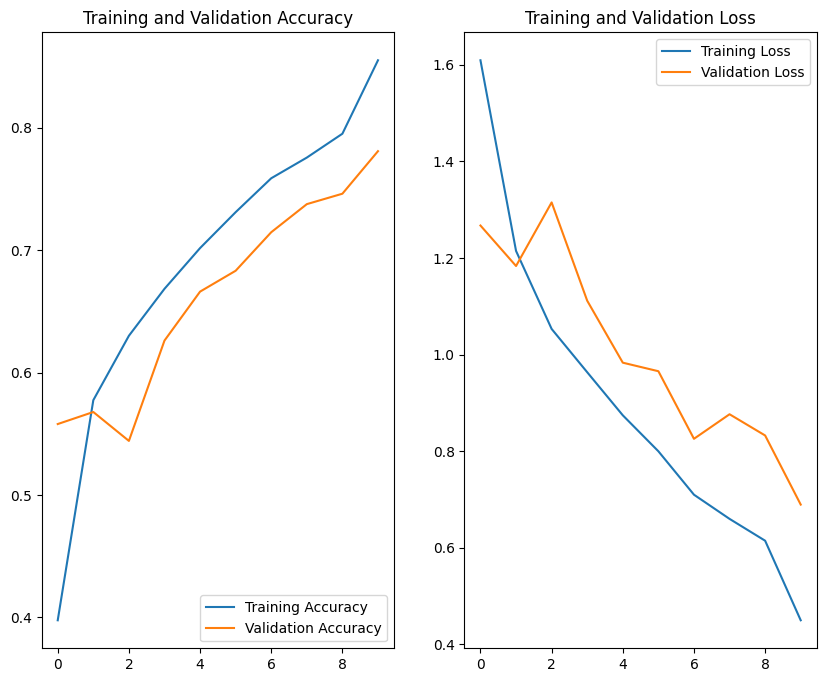

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize = (10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    batch_size = 1,
    seed = 123)

test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

Found 7625 files belonging to 7 classes.


In [31]:
# Generate predictions
model.load_weights('/content/vgg16_best_weights.hdf5.keras') # initialize the best trained weights
preds = model.predict(test_ds)
pred_classes = np.argmax(preds, axis = 1)

7625/7625 ━━━━━━━━━━━━━━━━━━━━ 1628s 213ms/step


In [35]:
model.evaluate(test_ds, verbose = 1)

7625/7625 ━━━━━━━━━━━━━━━━━━━━ 1614s 212ms/step - accuracy: 0.8936 - loss: 0.3192


[0.3844556510448456, 0.8726557493209839]

In [13]:
BATCH_SIZE = 64
img_height = 128
img_width = 128

import tensorflow as tf


def print_layer_trainable(): # Defining the function 'print_layer_trainable'
    for layer in base_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

IMG_SHAPE = (img_height, img_width, 3)
base_model = tf.keras.applications.VGG16(input_shape = IMG_SHAPE,
                                         include_top = False,
                                         weights = 'imagenet')


fine_tune  = base_model


fine_tune.trainable = True


for layer in fine_tune.layers:
    # Boolean whether this layer is trainable.
    trainable = ('block5' in layer.name or 'block4' in layer.name)

    # Set the layer's bool.
    layer.trainable = trainable


print_layer_trainable()



False:	input_layer_2
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


In [14]:


fine_tune.summary()



Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 12,979,200 (49.51 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

In [25]:
n_classes = len(class_names)

model2 = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    fine_tune,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation = 'softmax')
])

In [39]:
model2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,781,255 (56.39 MB)

 Trainable params: 13,045,767 (49.77 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

In [26]:
model2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [28]:
# Model Chackpoint
tl_checkpoint_1 = ModelCheckpoint(filepath = 'vgg16_best_weights_fine_tuning.hdf5.keras', save_best_only = True, verbose = 0)

# EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True, mode = 'min')

# Import ReduceLROnPlateau
from tensorflow.keras.callbacks import ReduceLROnPlateau

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.000001)


In [ ]:
%%time
history = model2.fit(train_ds,
                    epochs = 10,
                    validation_data = val_ds,
                    callbacks = [tl_checkpoint_1, early_stop, rop_callback])

Epoch 1/10
67/96 ━━━━━━━━━━━━━━━━━━━━ 10:41 22s/step - accuracy: 0.2287 - loss: 2.0845

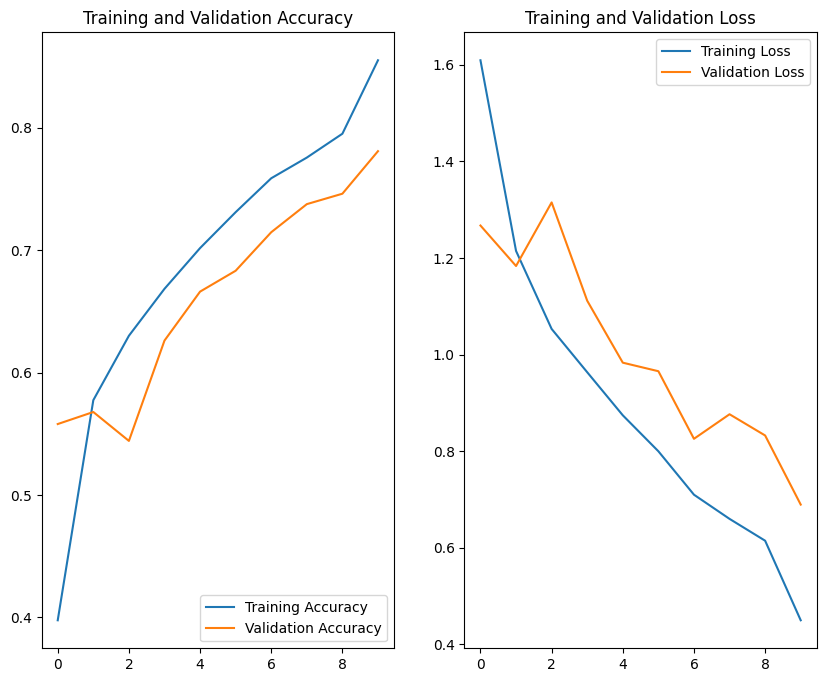

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize = (10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [31]:
AUTOTUNE = tf.data.AUTOTUNE # Define AUTOTUNE here using tf.data.AUTOTUNE

test_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    batch_size = 1,
    seed = 123)

test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

Found 7625 files belonging to 7 classes.


In [34]:
# Generate predictions
model2.load_weights('/content/vgg16_best_weights_fine_tuning.hdf5') # initialize the best trained weights
preds = model2.predict(test_ds)
pred_classes = np.argmax(preds, axis = 1)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/vgg16_best_weights_fine_tuning.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [33]:
model2.evaluate(test_ds, verbose = 1)

2681/7625 ━━━━━━━━━━━━━━━━━━━━ 15:17 186ms/step - accuracy: 0.2980 - loss: 1.8582

KeyboardInterrupt: 